In [12]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import MobileNet
from keras.utils import Sequence
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

dataset_code = 'B'
model_name = 'MobileNet'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
train_data_path = os.path.join(data_saved_dir, f'{dataset_code}_training.pkl')
train_images, train_labels = load_pickle(train_data_path)

val_data_path = os.path.join(data_saved_dir, 'B_validation_data.pkl')
val_images, val_labels = load_pickle(val_data_path)

In [14]:
print(f'Training data shape: {train_images.shape}')
print(f'Training labels shape: {train_labels.shape}')

print(f'Validation data shape: {val_images.shape}')
print(f'Validation labels shape: {val_labels.shape}')

Training data shape: (1787, 256, 256, 3)
Training labels shape: (1787,)
Validation data shape: (383, 256, 256, 3)
Validation labels shape: (383,)


In [15]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

batch_size = 16
train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)

In [16]:
_mobile_net = MobileNet(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

model = Sequential()
model.add(_mobile_net)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2048)              134219776 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 137,450,689
Trainable params: 134,221,825
Non-trainable params: 3,228,864
__________________________________

In [17]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator)

Epoch 1/50
112/112 [==============================] - 9s 50ms/step - loss: 9.7071 - accuracy: 0.8461 - val_loss: 2.4349 - val_accuracy: 0.9321
Epoch 2/50
112/112 [==============================] - 5s 43ms/step - loss: 1.9983 - accuracy: 0.9457 - val_loss: 2.3995 - val_accuracy: 0.9217
Epoch 3/50
112/112 [==============================] - 5s 43ms/step - loss: 0.7163 - accuracy: 0.9670 - val_loss: 2.3791 - val_accuracy: 0.9321
Epoch 4/50
112/112 [==============================] - 5s 42ms/step - loss: 0.2316 - accuracy: 0.9832 - val_loss: 2.2635 - val_accuracy: 0.9269
Epoch 5/50
112/112 [==============================] - 5s 42ms/step - loss: 0.3520 - accuracy: 0.9754 - val_loss: 2.2656 - val_accuracy: 0.9347
Epoch 6/50
112/112 [==============================] - 5s 43ms/step - loss: 0.4721 - accuracy: 0.9782 - val_loss: 2.7954 - val_accuracy: 0.9426
Epoch 7/50
112/112 [==============================] - 5s 43ms/step - loss: 0.2228 - accuracy: 0.9882 - val_loss: 2.8634 - val_accuracy: 0.9243

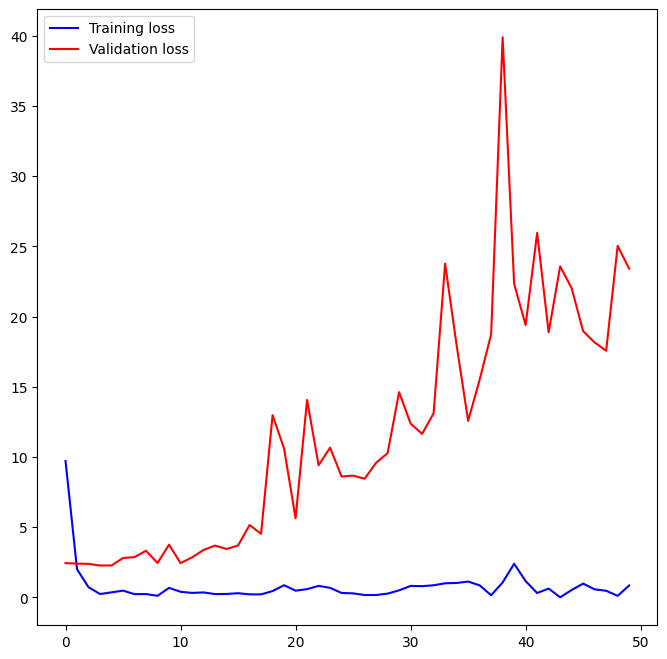

<Figure size 640x480 with 0 Axes>

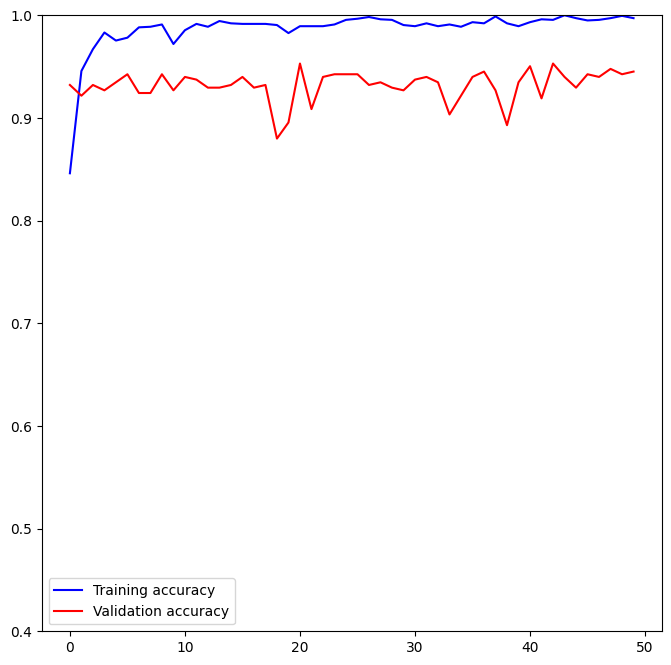

In [18]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.4, 1)
plt.show()

12/12 [==============================] - 1s 26ms/step


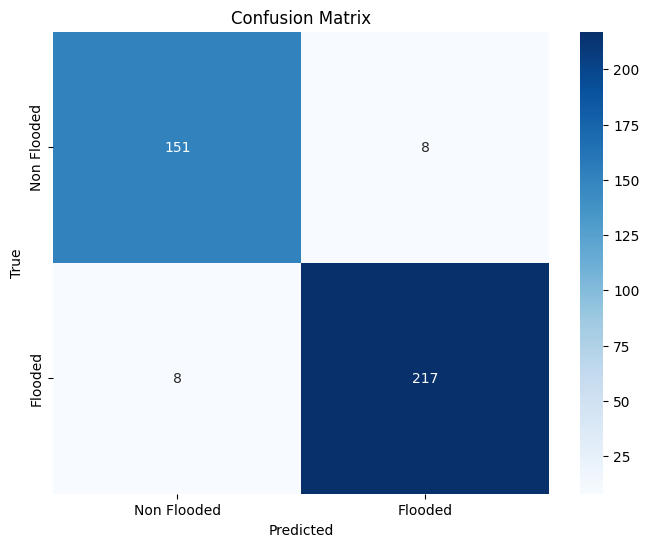

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       159
           1       0.96      0.96      0.96       225

    accuracy                           0.96       384
   macro avg       0.96      0.96      0.96       384
weighted avg       0.96      0.96      0.96       384



In [19]:
test_data_path = os.path.join(data_saved_dir, 'B_test_data.pkl')
test_images, test_labels = load_pickle(test_data_path)

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))